In [21]:
import pandas as pd
data = pd.read_csv('predict_pepland.csv')
data.head()

,Unnamed: 0,Peptides,Sequences,Smiles,Pubchem_CID,residue,IC50 (μmol/L),predict,Credibility
0,0,Pep2,R-G-D-X183-V,CC(C)[C@H](NC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@H](...,NaN,NaN,NaN,0.281779,0.217391
1,1,Pep3,R-G-D-X71-V,CC(C)[C@H](NC(=O)[C@@H](Cc1ccccc1)N(C)C(=O)[C@...,176873.0,N-methyl-d-phenylalanine,NaN,0.270079,0.185771
2,2,Pep4,R-G-D-X183-K,N=C(N)NCCC[C@H](N)C(=O)NCC(=O)N[C@@H](CC(=O)O)...,NaN,NaN,NaN,1.363864,0.173913
3,3,Pep5,R-G-D-X718-K,N=C(N)NCCC[C@H](N)C(=O)NCC(=O)N[C@@H](CC(=O)O)...,NaN,NaN,NaN,1.465840,0.177866
4,4,Pep6,R-G-D-X183-C,N=C(N)NCCC[C@H](N)C(=O)NCC(=O)N[C@@H](CC(=O)O)...,NaN,NaN,NaN,0.341346,0.162055


In [22]:
df = data.copy()
df['has_pep']    = df['Peptides'].str.contains('Pep',    case=False, na=False)
df['has_neg']    = df['Peptides'].str.contains('Neg',    case=False, na=False)
df['has_modify'] = df['Peptides'].str.contains('modify', case=False, na=False)
df['has_meg'] = df['Peptides'].str.contains('meg', case=False, na=False)

# 2. 聚合：mean + std
agg = (df.groupby(['has_pep', 'has_neg', 'has_modify','has_meg'])['predict']
         .agg(['mean', 'std'])
       )

has_pep vs has_neg: p = 0.004153
has_pep vs has_modify: p = 0.152176
has_pep vs has_meg: p = 0.479369
has_neg vs has_modify: p = 0.000046
has_neg vs has_meg: p = 0.000323
has_modify vs has_meg: p = 0.715975


/tmp/ipykernel_4053359/1311882831.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='flag', y='predict', data=df_long,


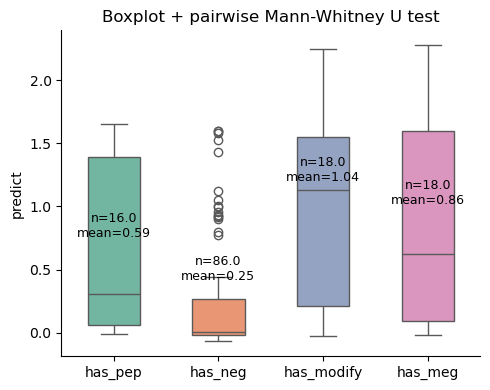

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu

# 1. 变长：保留 True 的行（含 has_meg）
df_long = (df.melt(id_vars=['predict'],
                   value_vars=['has_pep', 'has_neg', 'has_modify', 'has_meg'],
                   var_name='flag', value_name='bool_val')
             .query('bool_val == True'))

# 2. 每组 n / mean
flag_stats = (df_long.groupby('flag')['predict']
              .agg(['mean', 'count'])
              .reindex(['has_pep', 'has_neg', 'has_modify', 'has_meg']))

# 3. 两两 Mann-Whitney U 检验
pairs = [('has_pep', 'has_neg'),
         ('has_pep', 'has_modify'),
         ('has_pep', 'has_meg'),
         ('has_neg', 'has_modify'),
         ('has_neg', 'has_meg'),
         ('has_modify', 'has_meg')]
pvals = {}
for f1, f2 in pairs:
    x = df_long.loc[df_long['flag'] == f1, 'predict']
    y = df_long.loc[df_long['flag'] == f2, 'predict']
    _, p = mannwhitneyu(x, y, alternative='two-sided')
    pvals[(f1, f2)] = p

# 直接输出 p 值
for (f1, f2), p in pvals.items():
    print(f'{f1} vs {f2}: p = {p:.6f}')

# 4. 画图（不再标注 p 值）
plt.figure(figsize=(5, 4))
ax = sns.boxplot(x='flag', y='predict', data=df_long,
                 order=['has_pep', 'has_neg', 'has_modify', 'has_meg'],
                 width=0.5, palette='Set2')

# 5. 箱顶写 n / mean
for i, (flag, row) in enumerate(flag_stats.iterrows()):
    ytxt = row['mean'] + 0.06 * (df_long['predict'].max() -
                                 df_long['predict'].min())
    ax.text(i, ytxt, f"n={row['count']}\nmean={row['mean']:.2f}",
            ha='center', va='bottom', fontsize=9, color='k')

ax.set_xlabel('')
ax.set_ylabel('predict')
ax.set_title('Boxplot + pairwise Mann-Whitney U test')
sns.despine()
plt.tight_layout()
plt.show()